In [6]:
import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime as dt
# import seaborn as sns
# sns.set()
# from sklearn.cluster import KMeans
from lppls import lppls, data_loader
# import yfinance as yf

In [7]:
# Time Series loading

# data = yf.download('XRP-USD')
data = pd.read_csv('XRP-USD.csv')
# time1 = data.index
time = np.array(data.loc[:,"Date"].to_list())
time1 = [dt.strptime(d,'%Y-%m-%d').date() for d in time]
# time = [pd.Timestamp.toordinal(t1) for t1 in data.index]
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]
price = np.log(data['Adj Close'].values)
price1 = data['Adj Close'].values

T Critical: 2022-06-26 00:00:00
M: 0.44854511364533634
A: 0.41543330276123613
W: 3.335741125084457





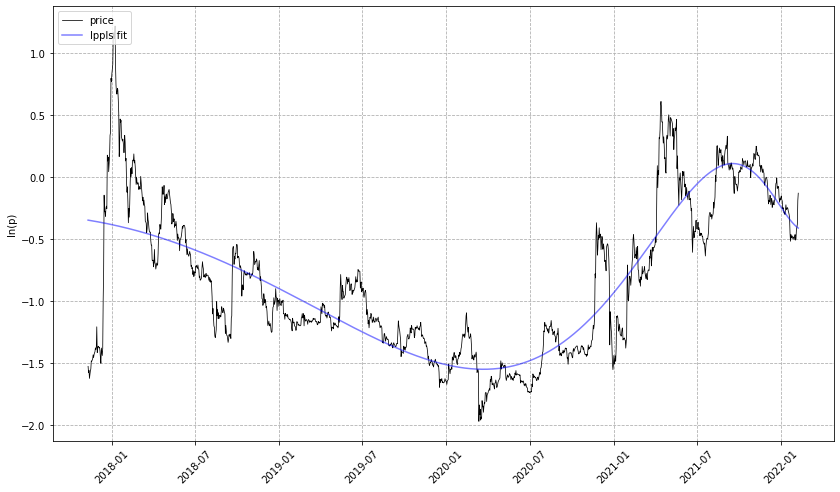

In [10]:
%matplotlib inline

observations = np.array([time[:], price[:]])
MAX_SEARCHES = 25
lppls_model = lppls.LPPLS(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)
print("T Critical: {}\nM: {}\nA: {}\nW: {}\n\n\n".format(dt.fromordinal(tc.astype(np.int64)),m,a,w))
lppls_model.plot_fit()

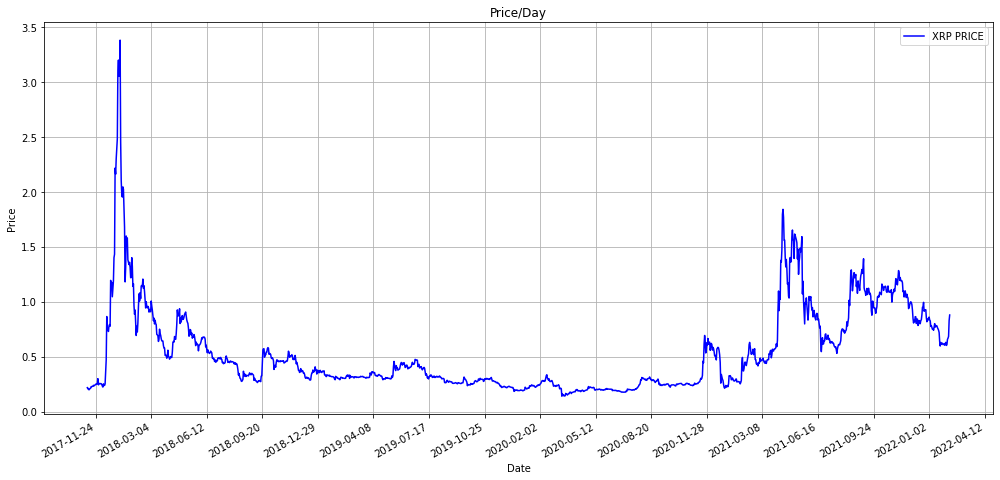

<Figure size 1224x576 with 0 Axes>

In [11]:
plt.rcParams['figure.figsize'] = [17,8]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.plot(time1[:],price1[:],color='b',label='XRP PRICE')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price/Day")
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
plt.show()
plt.clf()

100%|██████████| 1074/1074 [31:46<00:00,  1.78s/it] 


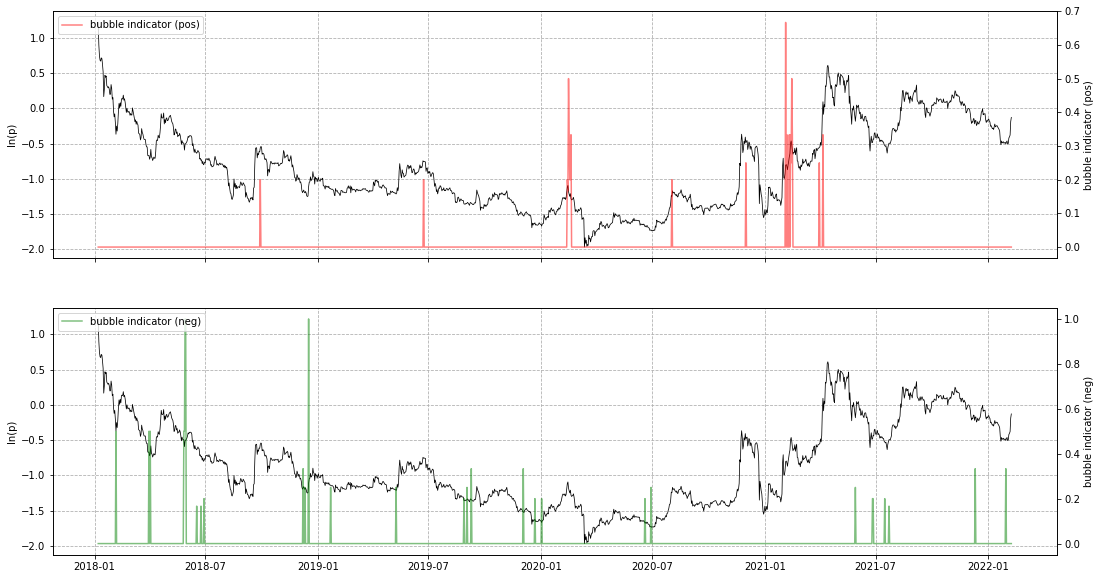

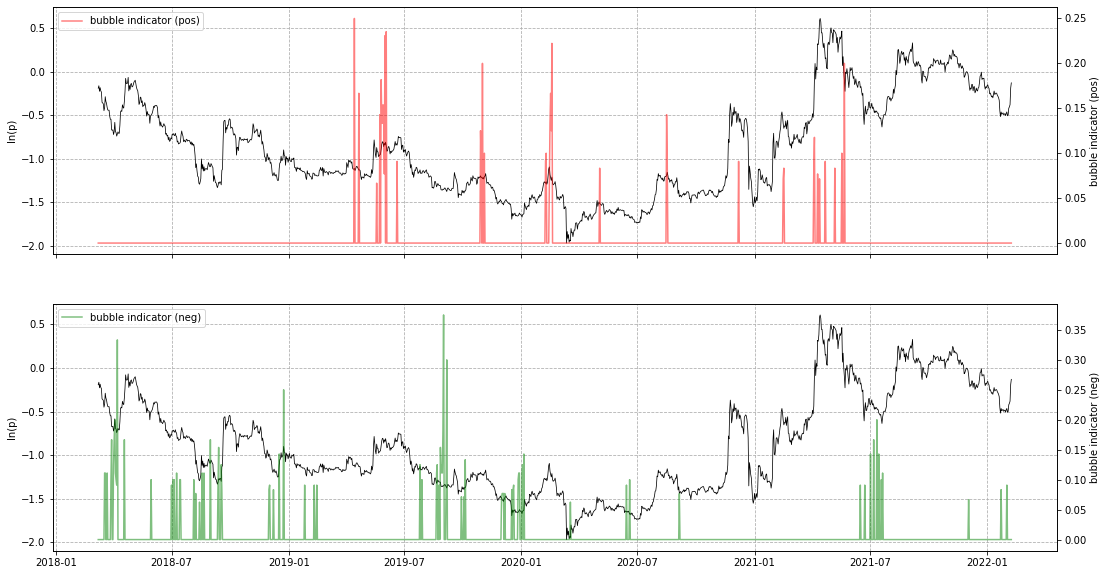

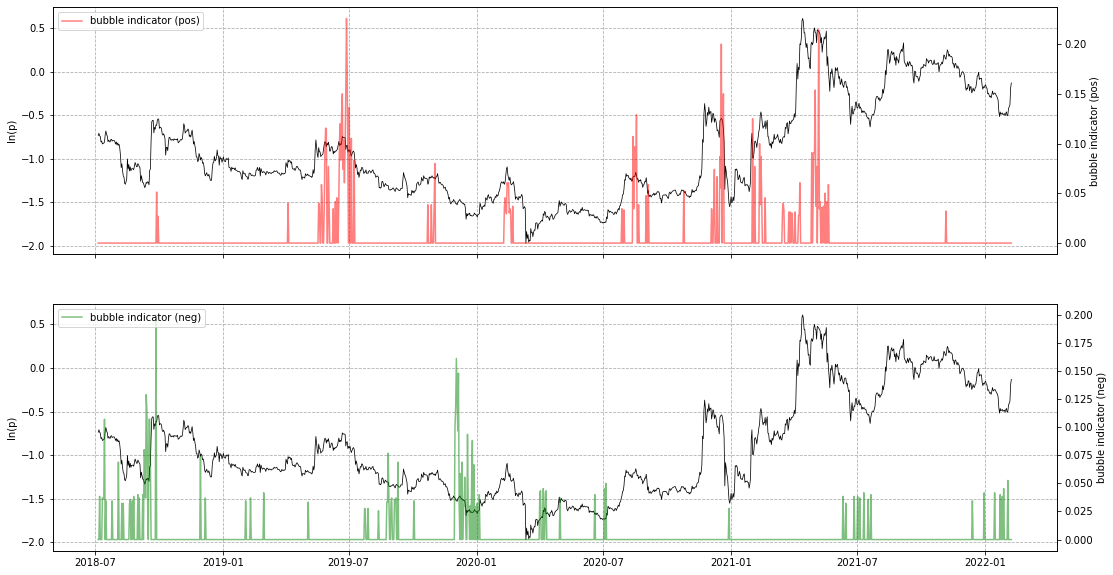

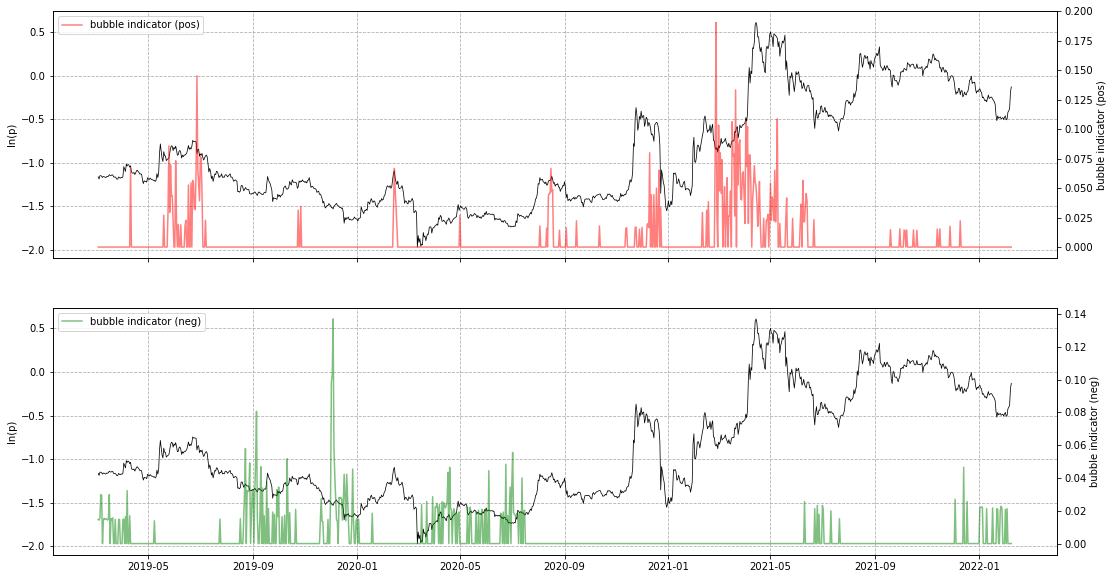

In [12]:
for w in [60,120,240,480]:
    res = lppls_model.mp_compute_nested_fits(
        workers=8,
        window_size=w, 
        smallest_window_size=30,
        outer_increment=1, 
        inner_increment=5, 
        max_searches=25,
        # filter_conditions_config={} # not implemented in 0.6.x
    )

    lppls_model.plot_confidence_indicators(res)
    plt.savefig('Figures/conf_ind_xrp_{}.jpg'.format(w))

    res_df = lppls_model.compute_indicators(res)

# CREATE RES AND TC CSV FILES FOR GIVEN WINDOW SIZE
    tc = []
    for i in res_df['_fits']:
        column = []
        for j in i:
            if j['tc'] > pd.Timestamp.toordinal(pd.Timestamp.max) or j['tc'] <= 1: 
                column.append(0)
                continue
            if type(j['tc'])!=type(1):
                column.append(pd.Timestamp.fromordinal(j['tc'].astype(np.int64)))
            else:
                column.append(pd.Timestamp.fromordinal(j['tc']))
        tc.append(column)

# CHANGE TIME VALUES IN RES_DF FROM ORDINAL TO TIMESTAMP
    d = {}
    for i in res_df['time']:
        d.update({int(i): pd.Timestamp.fromordinal(int(i))})
    res_df['time'] = res_df['time'].map(d)
    
    res_df.to_csv('res_{}.csv'.format(w))
    np.savetxt('tc_{}.csv'.format(w),tc,delimiter=',',fmt='%s')

In [26]:
 # IMPORTS
import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime as dt
# import seaborn as sns
# sns.set()
# from sklearn.cluster import KMeans
from lppls import lppls, data_loader
# import yfinance as yf

def min_find(date, ser):
    min_val = ser[0]
    for i in ser:
        if min_val != '0':
            if i!='0':
                tmp = dt.strptime(i, '%Y-%m-%d %H:%M:%S')
                tmp1 = dt.strptime(min_val, '%Y-%m-%d %H:%M:%S')
                if tmp1 > tmp:
                    if tmp.date() in date: 
                        min_val = i
        else:
            min_val = i
    tmp1 = dt.strptime(min_val, '%Y-%m-%d %H:%M:%S')
    if tmp1.date() not in date:
        min_val = date[0].strftime('%Y-%m-%d %H:%M:%S')
    return min_val

def max_find(date, ser):
    max_val = ser[0]
    for i in ser:
        if max_val != '0':
            if i!='0':
                tmp = dt.strptime(i, '%Y-%m-%d %H:%M:%S')
                tmp1 = dt.strptime(max_val, '%Y-%m-%d %H:%M:%S')
                if tmp1.date() not in date:
                    max_val = i
                    continue
                if tmp1 < tmp:
                    if tmp.date() in date: 
                        max_val = i
        else:
            max_val = i
    tmp1 = dt.strptime(max_val, '%Y-%m-%d %H:%M:%S')
    if tmp1.date() not in date:
        max_val = date[0].strftime('%Y-%m-%d %H:%M:%S')
    return max_val

def find_date(ar, tc):
    for i in range(len(ar)):
        if str(ar[i]) == str(tc):
            return i
    return -1

# Time Series loading

# data = yf.download('BTC-USD')
data = pd.read_csv('BTC-USD.csv')
# time1 = data.index
time = np.array(data.loc[:,"Date"].to_list())
time1 = [dt.strptime(d,'%Y-%m-%d').date() for d in time]
# time = [pd.Timestamp.toordinal(t1) for t1 in data.index]
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]
price = np.log(data['Adj Close'].values)
price1 = data['Adj Close'].values

plt.rcParams['figure.figsize'] = [17,8]

res = pd.read_csv('res_480.csv')
tc = pd.read_csv('tc_480.csv', header=None)
count = 0
for i in range(len(res['pos_conf'])):
    if res['pos_conf'][i]!=0 or res['neg_conf'][i]!=0:
        count += 1
            
        tc_min = min_find(time1[i+60:i+365], tc.iloc[i])
        if type(tc_min=='str'):
            tc_min = dt.strptime(tc_min, '%Y-%m-%d %H:%M:%S')
        tc_max = max_find(time1[i+60:i+365], tc.iloc[i])
        if type(tc_max=='str'):
            tc_max = dt.strptime(tc_max, '%Y-%m-%d %H:%M:%S')
            
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
        plt.plot(time1[i+60:i+365],price1[i+60:i+365],color='b',label='BITCOIN PRICE')
        plt.gcf().autofmt_xdate()
        plt.axvline(x=time1[i+60], color='g', linestyle='--', label='{}'.format(time1[i]))
        plt.axvline(x=tc_min, color='r', linestyle='--', label='{}'.format(tc_min))
        plt.axvline(x=tc_max, color='y', linestyle='--', label='{}'.format(tc_max))
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.title("Price/Day")
        plt.legend()
        plt.grid()
# plt.show()
        plt.savefig('Figures/frame{}'.format(count))
        plt.clf()

<Figure size 1224x576 with 0 Axes>

In [13]:
type(time1[60])

datetime.date

In [15]:
import os
os.getcwd()

'C:\\Users\\diama'